### Чек-лист:
1. Загрузите датасет taxi.csv.
2. Посмотрите на данные. Отобразите общую информацию по признакам (вспомните о describe и info). Напишите в markdown свои наблюдения.
3. Выявите пропуски, а также возможные причины их возникновения. Решите, что следует сделать с ними. Напишите в markdown свои наблюдения.
4. Оцените зависимости переменных между собой. Используйте корреляции. Будет хорошо, если воспользуетесь profile_report. Напишите в markdown свои наблюдения.
5. Определите стратегию преобразования категориальных признаков (т.е. как их сделать адекватными для моделей).
6. Найдите признаки, которые можно разделить на другие, или преобразовать в другой тип данных. Удалите лишние, при необходимости.
7. Разделите выборку на обучаемую и тестовую.
8. Обучите модель. Напишите в markdown свои наблюдения по полученным результатам. Хорошие результаты дают классификаторы RandomForest и XGBoost

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from sklearn import preprocessing
import xgboost 
from sklearn.metrics import accuracy_score

In [8]:
data = pd.read_csv('taxi.csv')
data.head()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
0,1105373,5,20,6080,174182,55.818842,37.334562,55.814567,37.355010,-1.000,-1.000,Economy,private,0
1,759733,5,14,6080,358774,55.805342,37.515023,55.819329,37.466398,18.802,25.217,Standard,private,1
2,416977,6,14,6080,866260,55.813978,37.347688,55.814827,37.354074,6.747,9.800,Economy,private,0
3,889660,2,6,6080,163522,55.745922,37.421748,55.743469,37.431130,-1.000,-1.000,Economy,private,1
4,1120055,4,16,6080,506710,55.803578,37.521602,55.812559,37.527407,12.383,19.250,Economy,private,1


### 
 - offer_gk - уникальный идентификатор заказа у клиента (случайное число) на нашу модель не повлияет;
 - weekday_key - день недели (важная величина), 0 - воскресенье, 1 - понедельник
 - hour_key - час заказа (важная величина), здесь все хорошо;
 - driver_gk - уникальный номер водителя (случайная величина), убираем;
 - order_gk - уникальный идентификатов заказа у водителя(случайное число), убираем;
 - все что связано с широтой и долготой оставлять не будем, потому что там имеется очень много уникальных значений;
 - distance_km - дистанция заказа в км (оставляем, есть значение с -1 и есть выброс в размере 5234);
 - duration_min - длительность поездки в мин (ее можем удалить, потому что она сильно коррелирует с дистанцией, логично что чем больше дистанция, тем больше длительность;
 - offer_class_group - класс заказа (важная величина, преобразуем с помощью labelinc );
 - ride_type_desc - тип заказа, частный или корпоративный (важная величина, преобразуем с помощью labelinc);
 - driver_response - выбор водителя (брать заказ - 1 или отказаться - 0), предсказываемая величина.

In [10]:
data.describe()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,driver_response
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,5.662189e+05,3.159860,13.827790,3446.376360,460867.01291,55.700824,37.492292,55.772440,37.541637,18.393518,23.134841,0.492480
std,3.259360e+05,2.054222,7.306496,2038.738677,266064.98953,2.135903,1.454640,0.665985,0.467758,41.129296,33.890105,0.499946
min,4.000000e+00,0.000000,0.000000,14.000000,18.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,2.855552e+05,1.000000,8.000000,1421.000000,229178.50000,55.708651,37.413497,55.708032,37.407117,-1.000000,-1.000000,0.000000
50%,5.656715e+05,3.000000,16.000000,3506.500000,462420.00000,55.772904,37.533664,55.772561,37.532537,10.411500,19.700000,0.000000
75%,8.487198e+05,5.000000,20.000000,5242.000000,690894.00000,55.960667,37.624113,55.962000,37.624358,30.665250,37.867000,1.000000
max,1.130355e+06,6.000000,23.000000,6806.000000,920344.00000,56.174097,38.280547,56.311121,38.243608,5234.283000,3958.283000,1.000000


In [11]:
data.info()
# отсутствующих значений нет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
offer_gk                  100000 non-null int64
weekday_key               100000 non-null int64
hour_key                  100000 non-null int64
driver_gk                 100000 non-null int64
order_gk                  100000 non-null int64
driver_latitude           100000 non-null float64
driver_longitude          100000 non-null float64
origin_order_latitude     100000 non-null float64
origin_order_longitude    100000 non-null float64
distance_km               100000 non-null float64
duration_min              100000 non-null float64
offer_class_group         100000 non-null object
ride_type_desc            100000 non-null object
driver_response           100000 non-null int64
dtypes: float64(6), int64(6), object(2)
memory usage: 10.7+ MB


In [12]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,driver_response
offer_gk,1,-0.00450622,-0.00694765,0.00147493,0.00333069,-0.00307526,-0.00361542,-0.00547202,-0.00677947,-0.00237002,-0.00225912,0.00515605
weekday_key,-0.00450622,1,0.0478799,0.0111469,0.000737523,-0.000229808,0.00648357,-0.0105301,0.0100811,-0.0293132,-0.0305336,0.0386101
hour_key,-0.00694765,0.0478799,1,-0.0373631,0.00616276,0.000306109,-0.00698976,0.00815618,-0.0162236,-0.0208573,-0.0261891,0.0195329
driver_gk,0.00147493,0.0111469,-0.0373631,1,-0.00414391,-0.0268707,-0.00411581,-0.0315773,0.042773,-0.00958102,-0.00408269,0.0157276
order_gk,0.00333069,0.000737523,0.00616276,-0.00414391,1,0.00451908,0.00325941,0.00553835,0.00128248,0.0021209,0.00319801,0.00166287
driver_latitude,-0.00307526,-0.000229808,0.000306109,-0.0268707,0.00451908,1,0.986198,0.0315682,-0.03647,0.0103413,0.0159911,-0.0519477
driver_longitude,-0.00361542,0.00648357,-0.00698976,-0.00411581,0.00325941,0.986198,1,-0.00332283,0.0170671,0.013402,0.0233367,-0.0198278
origin_order_latitude,-0.00547202,-0.0105301,0.00815618,-0.0315773,0.00553835,0.0315682,-0.00332283,1,0.856676,-0.000900407,-0.00591466,-0.0493775
origin_order_longitude,-0.00677947,0.0100811,-0.0162236,0.042773,0.00128248,-0.03647,0.0170671,0.856676,1,0.00974094,0.0183108,0.0532481
distance_km,-0.00237002,-0.0293132,-0.0208573,-0.00958102,0.0021209,0.0103413,0.013402,-0.000900407,0.00974094,1,0.977033,-0.140969


In [13]:
# удалим столбцы
data1 = data.drop(['offer_gk','driver_gk','order_gk','driver_latitude','driver_longitude','origin_order_latitude',
           'origin_order_longitude','duration_min'],axis=1)

In [14]:
data1.head()

,weekday_key,hour_key,distance_km,offer_class_group,ride_type_desc,driver_response
0,5,20,-1.000,Economy,private,0
1,5,14,18.802,Standard,private,1
2,6,14,6.747,Economy,private,0
3,2,6,-1.000,Economy,private,1
4,4,16,12.383,Economy,private,1


# работаем со столбцом distance_km

(array([9.9962e+04, 2.1000e+01, 1.0000e+01, 2.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([-1.0000000e+00,  5.2252830e+02,  1.0460566e+03,  1.5695849e+03,
         2.0931132e+03,  2.6166415e+03,  3.1401698e+03,  3.6636981e+03,
         4.1872264e+03,  4.7107547e+03,  5.2342830e+03]),
 <a list of 10 Patch objects>)

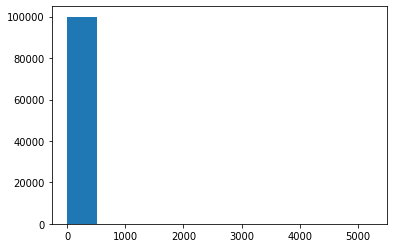

In [15]:
data1['distance_km'].value_counts()
# есть более 26 тыс значений с -1, предлагаю заменить на среднее значение
plt.hist(data1['distance_km'])
# по графику видим, что практически все заказы с дистанцией не более 100 км, поэтому все что свыше - уберем

In [16]:
data2 = data1.loc[data.distance_km <= 100.00000]
data2.describe()
#data2.info()
#в результате очистили датасет на 175 строк
data2.loc[data2['distance_km'].isin([-1]), 'distance_km'] = 17
# помимо это есть значение по дистанции с 0(предположим, что поедка была менее 1 км и ее округлили в меньшую 
# сторону - поэтому заменим на 1, а все что между 0 и 1 уберем);
data2.loc[data2['distance_km'].isin([0]), 'distance_km'] = 1
data2.describe()

/Users/mihailprihodko/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,weekday_key,hour_key,distance_km,driver_response
count,99825.000000,99825.000000,99825.000000,99825.000000
mean,3.159609,13.828830,22.383298,0.492442
std,2.054031,7.305231,16.947172,0.499945
min,0.000000,0.000000,0.005000,0.000000
25%,1.000000,8.000000,10.967000,0.000000
50%,3.000000,16.000000,17.000000,0.000000
75%,5.000000,20.000000,30.477000,1.000000
max,6.000000,23.000000,99.596000,1.000000


# работаем со столбцом offer_class_group

In [17]:
data2['offer_class_group'].value_counts()
# уберем из выборки Test, объединим VIP и VIP+
data3 = data2[data2['offer_class_group'].isin(['Economy', 'Standard','Premium','Delivery','Kids','XL','VIP','VIP+'])]
data3.loc[data2['offer_class_group'].isin(['VIP','VIP+']), 'offer_class_group'] = 'VIP'
data3['offer_class_group'].value_counts()

Economy     48232
Standard    47231
Premium      1765
Delivery     1290
Kids          587
XL            462
VIP           250
Name: offer_class_group, dtype: int64

In [18]:
# используя LabelEncoder преобразуем категориальные признаки для работы модели

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data3['offer_class_group'] = le.fit_transform(data3.offer_class_group)
data3.head()

/Users/mihailprihodko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,weekday_key,hour_key,distance_km,offer_class_group,ride_type_desc,driver_response
0,5,20,17.000,1,private,0
1,5,14,18.802,4,private,1
2,6,14,6.747,1,private,0
3,2,6,17.000,1,private,1
4,4,16,12.383,1,private,1


# работаем со столбцом ride_type_desc

In [19]:
data3['ride_type_desc'].value_counts()
# так как данных affiliate и SMB немного, их уберем;
data4 = data3[data3['ride_type_desc'].isin(['private', 'business'])]
data4['ride_type_desc'].value_counts()
# заменим с помощью replace
data4.ride_type_desc.replace(['private','business'],[0,1], inplace = True)
data4.head(10)

/Users/mihailprihodko/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


,weekday_key,hour_key,distance_km,offer_class_group,ride_type_desc,driver_response
0,5,20,17.000,1,0,0
1,5,14,18.802,4,0,1
2,6,14,6.747,1,0,0
3,2,6,17.000,1,0,1
4,4,16,12.383,1,0,1
5,6,15,6.747,1,0,0
6,2,11,17.000,4,1,1
7,5,20,1.517,1,0,0
8,5,20,6.222,1,0,0
9,6,7,10.410,1,0,0


In [20]:
X = data4.drop(['driver_response'],axis = 1)
y = data4['driver_response']

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [23]:
from sklearn.ensemble import RandomForestClassifier

# создаем модель деревья решений
# выбираем 100 деревьев в качестве параметра
model=RandomForestClassifier(n_estimators=100)

# обучаем модель
model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

No handles with labels found to put in legend.


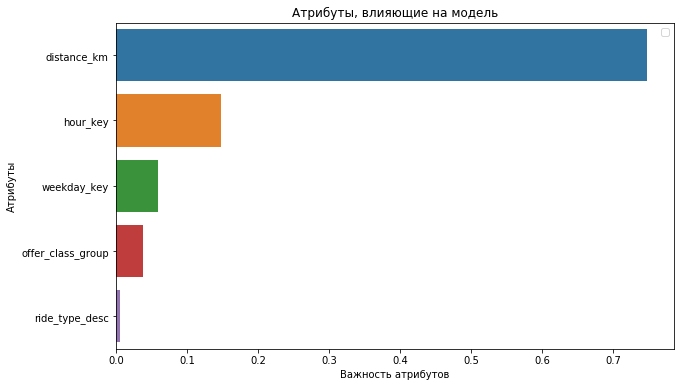

In [24]:
feature_imp = pd.Series(model.feature_importances_,index=list(X.columns.values)).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Важность атрибутов')
plt.ylabel('Атрибуты')
plt.title("Атрибуты, влияющие на модель")
plt.legend()
plt.show()


In [25]:
# посчитаем качество модели
model_pred = model.predict(X_test)

print(classification_report(y_test, model_pred))

model.score(X_test, y_test)

              precision    recall  f1-score   support

           0       0.67      0.68      0.67     10063
           1       0.67      0.65      0.66      9850

    accuracy                           0.67     19913
   macro avg       0.67      0.67      0.67     19913
weighted avg       0.67      0.67      0.67     19913



0.6658966504293677

# после проведения нормализации


In [26]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
np_scaled = min_max_scaler.fit_transform(X)
X_norm = pd.DataFrame(np_scaled)
X_norm.head()

,0,1,2,3,4
0,0.833333,0.869565,0.170648,0.166667,0.0
1,0.833333,0.608696,0.188742,0.666667,0.0
2,1.000000,0.608696,0.067697,0.166667,0.0
3,0.333333,0.260870,0.170648,0.166667,0.0
4,0.666667,0.695652,0.124288,0.166667,0.0


In [27]:
# присвоим изначальное наименование столбцов
headers = list(X.columns.values)
X_norm.columns = headers
X_norm.head()

,weekday_key,hour_key,distance_km,offer_class_group,ride_type_desc
0,0.833333,0.869565,0.170648,0.166667,0.0
1,0.833333,0.608696,0.188742,0.666667,0.0
2,1.000000,0.608696,0.067697,0.166667,0.0
3,0.333333,0.260870,0.170648,0.166667,0.0
4,0.666667,0.695652,0.124288,0.166667,0.0


In [28]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_norm, y, test_size=0.2)

In [29]:
from sklearn.ensemble import RandomForestClassifier

# создаем модель деревья решений
# выбираем 100 деревьев в качестве параметра
model=RandomForestClassifier(n_estimators=100)

# обучаем модель
model.fit(X_train_1,y_train_1)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [30]:
# посчитаем качество модели
model_pred = model.predict(X_test)

print(classification_report(y_test, model_pred))

model.score(X_test, y_test)
# после нормализации стало хуже;

              precision    recall  f1-score   support

           0       0.61      0.01      0.03     10063
           1       0.50      0.99      0.66      9850

    accuracy                           0.50     19913
   macro avg       0.55      0.50      0.34     19913
weighted avg       0.55      0.50      0.34     19913



0.49726309446090494

# используем XGBoost


In [38]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.2)

In [39]:
model = xgboost.XGBClassifier()
model.fit(X_train_2, y_train_2)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [40]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [42]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 68.37%
